In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.cluster import hierarchy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import utility_functions as fn

In [3]:
# import preprocessed energy and weather data
energy = pd.read_csv('../data/elec_clean.csv',index_col=0)
energy.index = pd.to_datetime(energy.index,format='%Y-%m-%d %H:00:00')

weather = pd.read_csv('../data/weather_clean.csv',index_col=0)
weather.index = pd.to_datetime(weather.index,format='%Y-%m-%d %H:00:00')

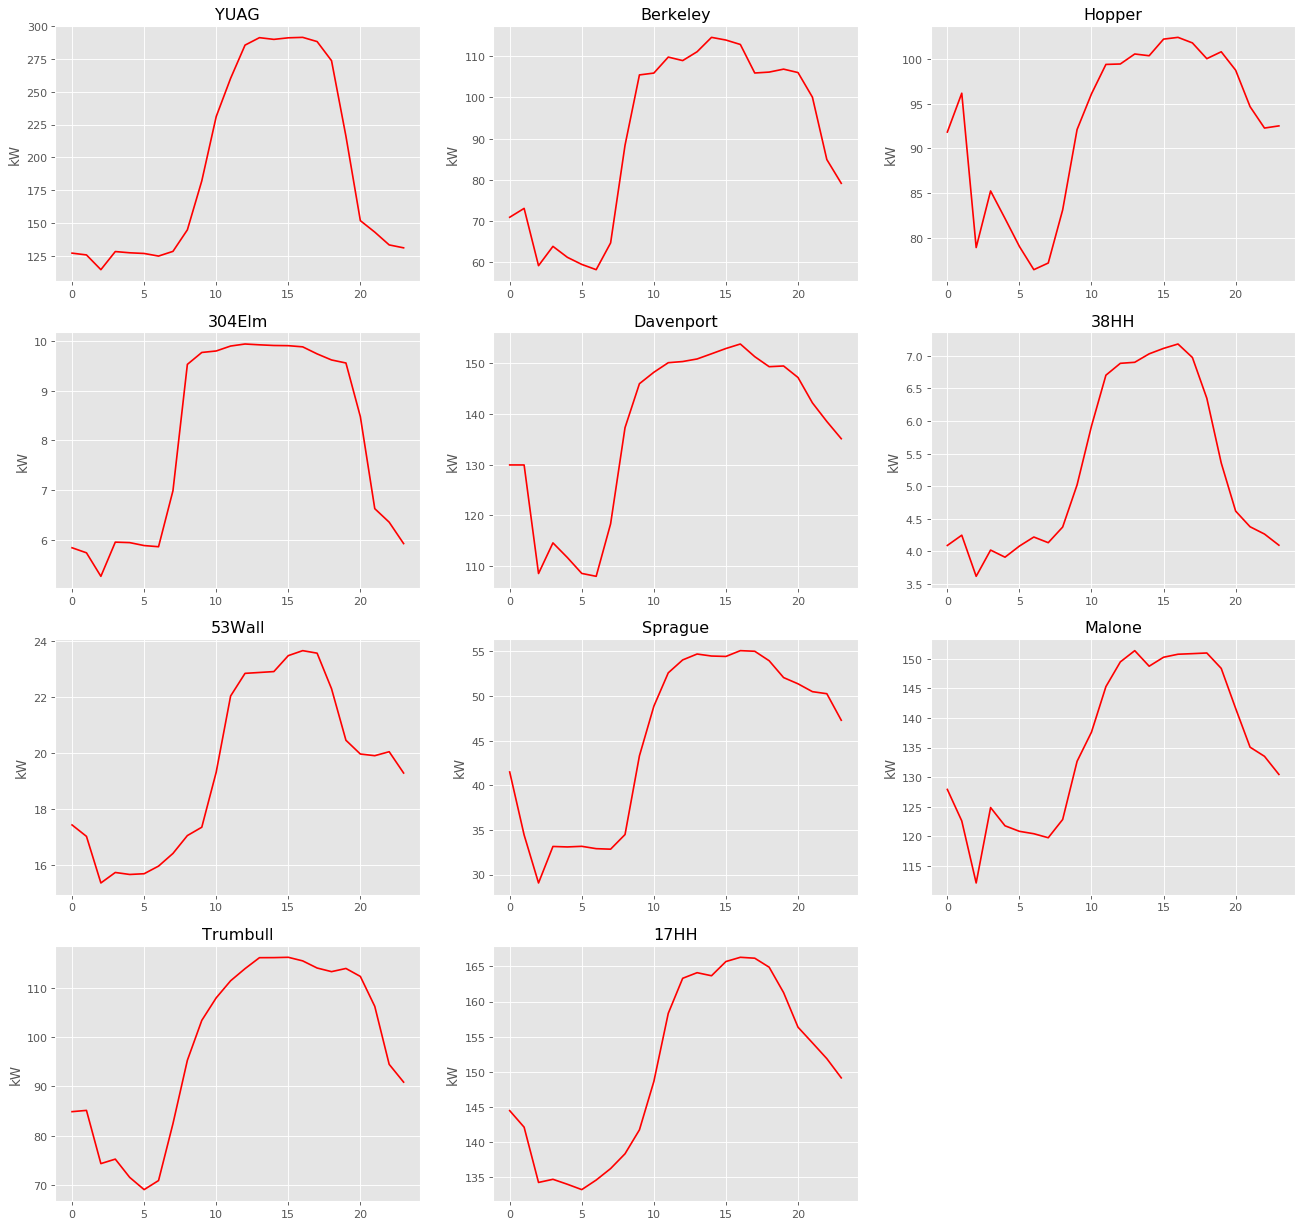

In [4]:
hourofday = energy.groupby(energy.index.hour).apply(np.mean)

fn.plot_all(hourofday,0,23,ylabel='kW')

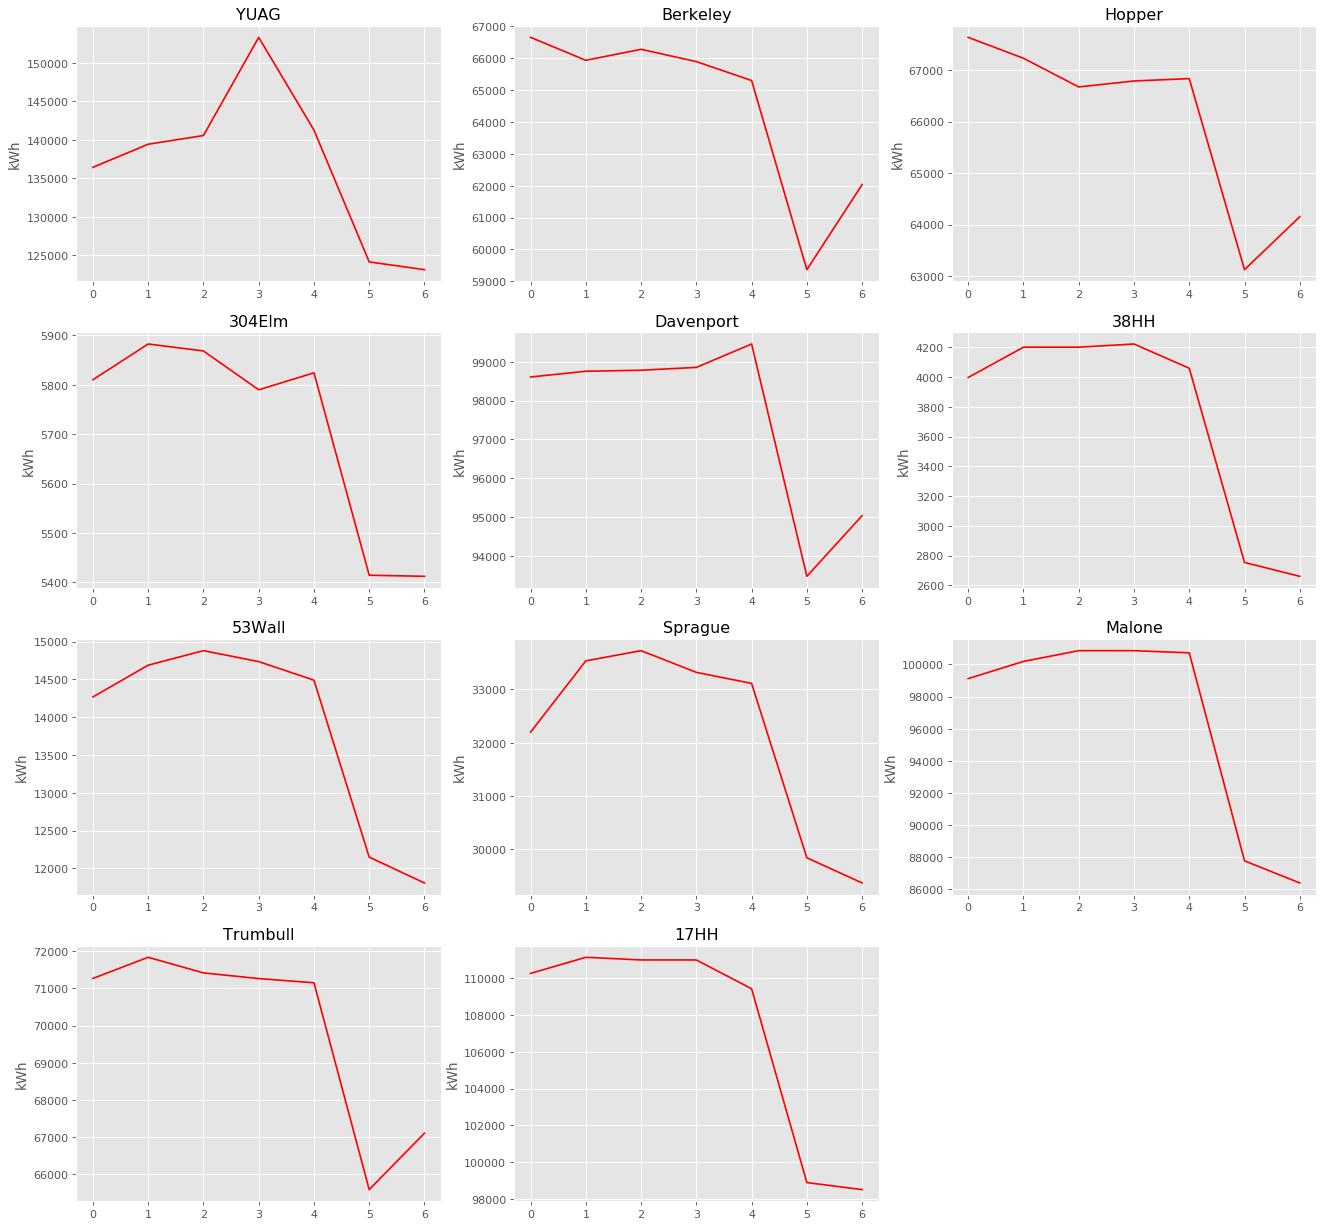

In [5]:
dayofweek = energy.groupby(energy.index.dayofweek).apply(np.sum)

fn.plot_all(dayofweek,0,6,ylabel='kWh')

In [7]:
weekofyear = energy.groupby(energy.index.weekofyear).apply(np.sum)

# fn.plot_all(weekofyear,1,30,ylabel='kWh')

In [8]:
# implement sklearn scaler to normalize daily and weekly profiles
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

hourofday_norm = pd.DataFrame(scaler.fit_transform(hourofday.values))
hourofday_norm.columns = hourofday.columns

dayofweek_norm = pd.DataFrame(scaler.fit_transform(dayofweek.values))
dayofweek_norm.columns = dayofweek.columns

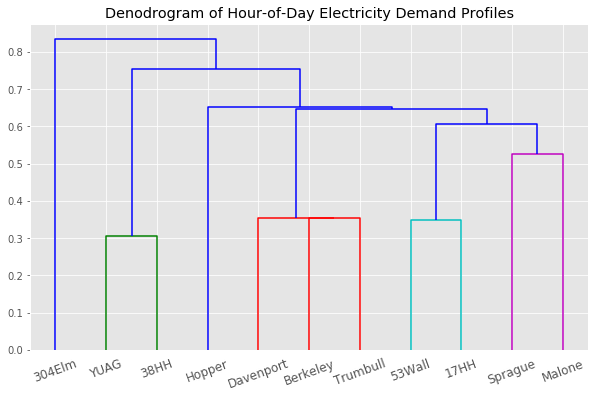

In [7]:
# plot dendrogram of hour-of-day data
from scipy.cluster import hierarchy

linked = hierarchy.linkage(hourofday_norm.values.T,'single')
labels = hourofday_norm.columns

plt.figure(figsize=(10, 6))
hierarchy.dendrogram(linked,
                     orientation='top',
                     labels=labels,
                     distance_sort='descending',
                     show_leaf_counts=True)
plt.xticks(rotation=20)
plt.title('Dendrogram of Hour-of-Day Electricity Demand Profiles')
plt.show()

In [8]:
# could package this cell as def clusters(df,n_clusters): -> return dict clusters[n]

# define number of clusters based on the dendrogram (longest vertical line rule)
n_clusters = 6

# use agglomerative clustering to create exactly n clusters
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clustering_result_array = agg_cluster.fit_predict(hourofday_norm.values.T)

# this loop populates a dict of DataFrames for each cluster called clusters[n]
clusters = {}
for n in range(n_clusters):
    match_indices = [i for i, x in enumerate(clustering_result_array == n) if x]
    clusters[n] = hourofday.iloc[:,match_indices]

# print the clustering results
for n in range(n_clusters):
    print('Cluster '+str(n)+': '+str([k for k in clusters[n].columns]))

Cluster 0: ['Sprague', 'Malone']
Cluster 1: ['Berkeley', 'Davenport', 'Trumbull']
Cluster 2: ['304Elm']
Cluster 3: ['YUAG', '38HH']
Cluster 4: ['53Wall', '17HH']
Cluster 5: ['Hopper']


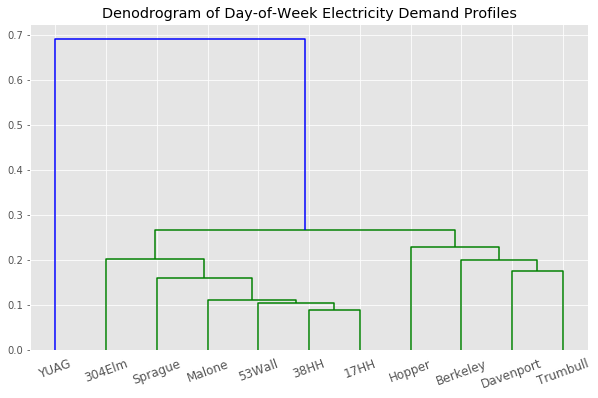

In [9]:
# find hierarchical clustering linkages
linked = hierarchy.linkage(dayofweek_norm.values.T,'single')

# plot dendrogram of linkages to inform n_clusters
plt.figure(figsize=(10, 6))
labels = dayofweek_norm.columns
hierarchy.dendrogram(linked,  
                     orientation='top',
                     labels=labels,
                     distance_sort='descending',
                     show_leaf_counts=True)
plt.xticks(rotation=20)
plt.title('Dendrogram of Day-of-Week Electricity Demand Profiles')
plt.show()

In [10]:
# define number of clusters based on the dendrogram (longest vertical line rule)
n_clusters = 2

# use agglomerative clustering to create exactly n clusters
from sklearn.cluster import AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clustering_result_array = agg_cluster.fit_predict(dayofweek_norm.values.T)

# this loop populates a dict of DataFrames for each cluster called clusters[n]
clusters = {}
for n in range(n_clusters):
    match_indices = [i for i, x in enumerate(clustering_result_array == n) if x]
    clusters[n] = hourofday.iloc[:,match_indices]

# print the clustering results
for n in range(n_clusters):
    print('Cluster '+str(n)+': '+str([k for k in clusters[n].columns]))

Cluster 0: ['Berkeley', 'Hopper', '304Elm', 'Davenport', '38HH', '53Wall', 'Sprague', 'Malone', 'Trumbull', '17HH']
Cluster 1: ['YUAG']
